In [27]:
import xarray as xr
import numpy as np
from scipy import ndimage, misc
from scipy.signal.signaltools import wiener
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.pyplot as plt
from climatico import enso

In [2]:
pac_itcz = enso.DefineNino(nino='pacitcz', lats='lat', lons='lon')
atl_itcz = enso.DefineNino(nino='atlitcz', lats='lat', lons='lon')

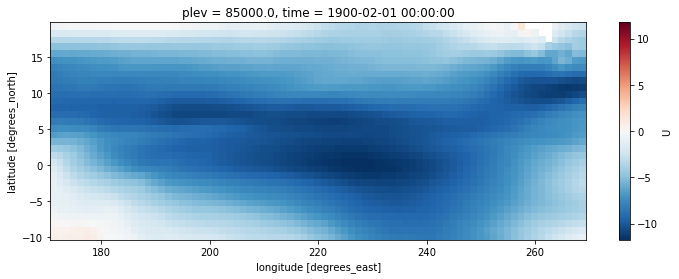

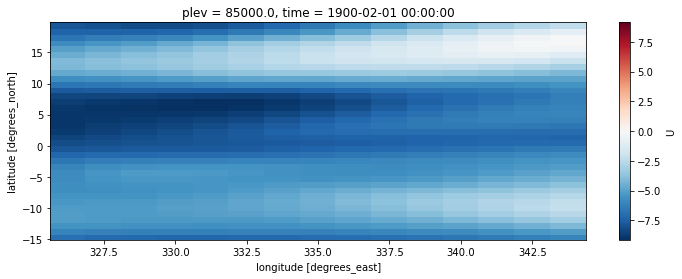

In [3]:
xr.open_mfdataset('/glade/scratch/molina/amoc_exp/b.e11.B1850C5CN.f09_g16.005.cam.850.U.190001-199912.nc',
                  preprocess=pac_itcz.nino).isel(time=0,plev=0)['U'].plot.pcolormesh(figsize=(12,4)); plt.show()

xr.open_mfdataset('/glade/scratch/molina/amoc_exp/b.e11.B1850C5CN.f09_g16.005.cam.850.U.190001-199912.nc',
                  preprocess=atl_itcz.nino).isel(time=0,plev=0)['U'].plot.pcolormesh(figsize=(12,4)); plt.show()

In [4]:
u_pac = xr.open_mfdataset('/glade/scratch/molina/amoc_exp/b.e11.B1850C5CN.f09_g16.005.cam.850.U.190001-199912.nc',
                          preprocess=pac_itcz.nino).isel(plev=0)['U'].fillna(0.0)

lat_pac = u_pac.coords['lat']
lon_pac = u_pac.coords['lon']
time_pac = u_pac.coords['time']
u_pac = u_pac.values

v_pac = xr.open_mfdataset('/glade/scratch/molina/amoc_exp/b.e11.B1850C5CN.f09_g16.005.cam.850.V.190001-199912.nc',
                          preprocess=pac_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_pac = v_pac.values

In [5]:
u_atl = xr.open_mfdataset('/glade/scratch/molina/amoc_exp/b.e11.B1850C5CN.f09_g16.005.cam.850.U.190001-199912.nc',
                          preprocess=atl_itcz.nino).isel(plev=0)['U'].fillna(0.0)

lat_atl = u_atl.coords['lat']
lon_atl = u_atl.coords['lon']
time_atl = u_atl.coords['time']
u_atl = u_atl.values

v_atl = xr.open_mfdataset('/glade/scratch/molina/amoc_exp/b.e11.B1850C5CN.f09_g16.005.cam.850.V.190001-199912.nc',
                          preprocess=atl_itcz.nino).isel(plev=0)['V'].fillna(0.0)
v_atl = v_atl.values

In [39]:
def wind_convergence(U,V):
    """
    Compute wind convergence.
    
    Args:
        U, V: u and v winds as arrays. Must be 3d (time, lat, lon).
        
    Notes:
        Method for determing shifts in ITCZ using wind convergence, from:
        https://scholarcommons.usf.edu/cgi/viewcontent.cgi?referer=https://www.google.com/&httpsredir=1&article=7842&context=etd
    """
    [du_dx, du_dy] = np.gradient(U, axis=[1,2])
    [dv_dx, dv_dy] = np.gradient(V, axis=[1,2])
    divergence = du_dx + dv_dy
    return divergence * -1

def get_itcz_matrix(U, V):
    """
    Compute estimated ITCZ position using max latitude per longitude and various smoothers for convergence noise.
    
    Args:
        U, V: u and v winds as arrays. Must be 3d (time, lat, lon).
        
    Returns:
        binary mask and binary mask with 6-month running mean.
    """
    # compute convergence, running mean filter of 3, adaptive low-pass filter -- wiener  
    #tmp_itcz = wiener(ndimage.uniform_filter(wind_convergence(U, V), size=5))
    tmp_itcz = wiener(gaussian_filter(wind_convergence(U, V), sigma=1.5))
    # grab max values
    itcz_locs = np.argmax(tmp_itcz[:,:,:],axis=1)
    # create zero array
    mask_itcz = np.zeros((tmp_itcz.shape))
    # fill itcz mask
    for time in range(tmp_itcz.shape[0]):
        for enum, i in enumerate(itcz_locs[time]):
            mask_itcz[time,i,enum] =+ 1
    # 6 mo running mean of mask
    mask_itcz_6mo = uniform_filter1d(mask_itcz, 6, axis=0)
    return mask_itcz, mask_itcz_6mo

def get_itcz_latitude(U, V, lat, lon):
    """
    Compute estimated ITCZ latitude using max latitude per longitude and various smoothers for convergence noise.
    
    Args:
        U, V: u and v winds as arrays. Must be 3d (time, lat, lon).
        
    Returns:
        binary mask and binary mask with 6-month running mean.
    """
    # compute convergence, running mean filter of 3, adaptive low-pass filter -- wiener  
    #tmp_itcz = wiener(ndimage.uniform_filter(wind_convergence(u_wnd, v_wnd), size=3))
    tmp_itcz = wiener(gaussian_filter(wind_convergence(u_wnd, v_wnd), sigma=1.5))
    # grab max values
    itcz_locs = np.argmax(tmp_itcz[:,:,:],axis=1)
    # create zero array
    mask_itcz = np.zeros((tmp_itcz.shape))
    # fill itcz mask
    for time in range(tmp_itcz.shape[0]):
        for enum, i in enumerate(itcz_locs[time]):
            mask_itcz[time,i,enum] =+ 1
    # 6 mo running mean of mask
    mask_itcz_6mo = uniform_filter1d(mask_itcz, 6, axis=0)
    return mask_itcz, mask_itcz_6mo

def create_itcz_ds(mask1, mask2, time, lat, lon):
    """
    Assemble as xr.Dataset
    """
    return xr.Dataset(
               {'itcz':    (['time','lat','lon'],m_itcz),
                'itcz_6mo':(['time','lat','lon'],m_itcz_6mo)},
               coords={
                   'time':(['time'],time),
                   'lat':(['lat'],lat),
                   'lon':(['lon'],lon)})

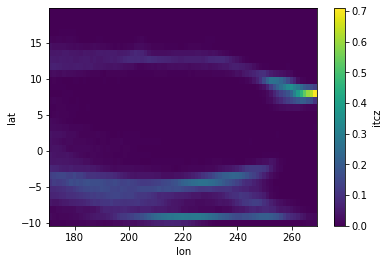

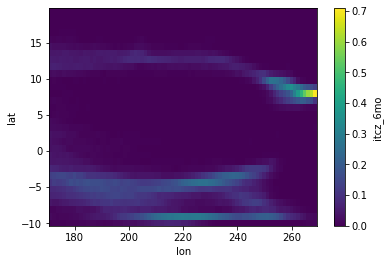

In [40]:
m_itcz, m_itcz_6mo = get_itcz_matrix(u_pac, v_pac)
ds_itcz = create_itcz_ds(m_itcz, m_itcz_6mo, time_pac, lat_pac, lon_pac)
ds_itcz.mean('time')['itcz'].plot.pcolormesh(); plt.show()
ds_itcz.mean('time')['itcz_6mo'].plot.pcolormesh()

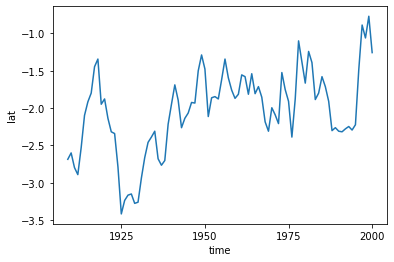

In [41]:
ds_itcz['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=10).mean().plot()

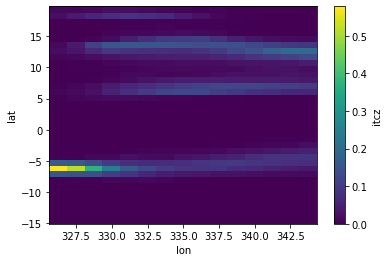

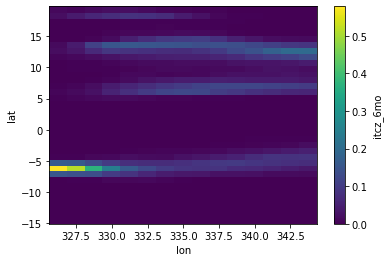

In [42]:
m_itcz, m_itcz_6mo = get_itcz_matrix(u_atl, v_atl)
ds_itcz = create_itcz_ds(m_itcz, m_itcz_6mo, time_atl, lat_atl, lon_atl)
ds_itcz.mean('time')['itcz'].plot.pcolormesh(); plt.show()
ds_itcz.mean('time')['itcz_6mo'].plot.pcolormesh()

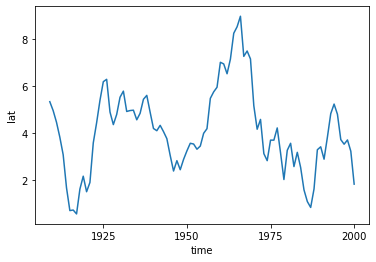

In [37]:
ds_itcz['itcz'].idxmax('lat').median('lon').resample(time='AS').mean().rolling(time=10).mean().plot()